In [76]:
import pandas as pd
import numpy as np
# import pygad # Wrote everything ourselves
import random
import copy
import time as t

In [77]:
import csv

# Initialize an empty dictionary
engine_RUL_full_consultancy = {}

with open('RUL_consultancy_predictions_A3-2.csv', newline='') as csvfile:
    # Create a CSV reader object with semicolon as delimiter
    reader = csv.reader(csvfile, delimiter=';')
    # Skip the header row
    next(reader)
    # Loop over each row in the CSV
    for row in reader:
        # Check if row has exactly 2 columns
        if len(row) == 2:
            engine_RUL_full_consultancy[int(row[1])] = int(row[0])

In [78]:
# Initialize an empty dictionary
engine_RUL_own_predictions = {}

with open('RUL_own_predictions_A3.csv', newline='') as csvfile:
    # Create a CSV reader object with semicolon as delimiter
    reader = csv.reader(csvfile, delimiter=';')
    # Skip the header row
    next(reader)
    # Loop over each row in the CSV
    for row in reader:
        # Check if row has exactly 2 columns
        if len(row) == 2:
            engine_RUL_own_predictions[int(row[1])] = int(row[0])


In [79]:
engine_RUL_30 = {key: value for key, value in engine_RUL_full_consultancy.items() if value <= 30}

In [80]:
Team_A_time = {key: 4 for key in range(1, 21)}
Team_A_time.update({key: 3 for key in range(21, 56)})
Team_A_time.update({key: 2 for key in range(56, 81)})
Team_A_time.update({key: 8 for key in range(81, 101)})

Team_B_time = {j : Team_A_time[j] + 1 for j in range(1, 26)}
Team_B_time.update({j : Team_A_time[j] + 2 for j in range(26, 71)})
Team_B_time.update({j : Team_A_time[j] + 1 for j in range(71, 101)})

In [81]:
T1_time = Team_A_time
T2_time = Team_B_time
T3_time = Team_A_time
T4_time = Team_B_time

## 2.1 Genetic Algorithm

# Random Initializer

In [82]:
def calculate_team_work_time(team, engines):
    """ Calculate the time it takes for a team to fix a list of engines
    
    Parameters:
        team : str
            Team name
        engines : list
            List of engines to fix
    
    Returns:
        time : int
            Time it takes for the team to fix the engines
    """
    if team in ["T1", "T3"]:
        engine_times = Team_A_time
    else:
        engine_times = Team_B_time
    
    time = 0
    
    for engine in engines:
        time += engine_times[engine]
    
    return time
    

def random_init(engines_RUL):
    """ Randomly initialize a schedule
    
    Parameters:
        engines_RUL : dict
            Dictionary with the RUL of each engine
    
    Returns:
        schedule : dict
            Dictionary with the schedule
    """
    schedule = {"T1":[], "T2":[], "T3":[], "T4":[]}
    
    possible_engines = list(engines_RUL.keys())
    possible_teams = ["T1", "T2", "T3", "T4"]
    
    iterations = 0 
    
    while possible_engines and iterations < 500:
        index = random.randrange(4)
        team = possible_teams[index]
        
        index = random.randrange(len(possible_engines))
        selected_engine = possible_engines[index]
        
        schedule[team].append(selected_engine)
        
        possible_engines.remove(selected_engine)
        
        iterations += 1

    return schedule

In [83]:
random_init(engine_RUL_30)

{'T1': [20, 35, 31, 77, 36, 68, 100],
 'T2': [90, 66, 76],
 'T3': [91, 40, 64, 81, 37, 61, 82, 24, 41],
 'T4': [34, 42, 49, 92, 56]}

# Loss Function

In [84]:
def engine_fix_date(schedule):
    """ Calculate when each engine will be fixed
    
    Parameters:
        schedule : dict
            Dictionary with the schedule
    
    Returns:
        engine_fix : dict
            Dictionary with the fix date of each engine
    """
    engine_fix = {}
    for team in schedule:
        days = 0
        if team == "T1" or team == "T3":
            time_table = Team_A_time
        else:
            time_table = Team_B_time
            
        for engine in schedule[team]:
            engine_fix[engine] = days
            days = days + time_table[engine]
    return engine_fix

def engine_finish_date(fix_date, schedule):
    """ Calculate when each engine will be finished
    
    Parameters:
        fix_date : dict
            Dictionary with the fix date of each engine
        schedule : dict
            Dictionary with the schedule
    
    Returns:
        engine_finish : dict
            Dictionary with the finish date of each engine
    """
    engine_finish = {}
    for team in schedule:
        if team == "T1" or team == "T3":
            time_table = Team_A_time
        else:
            time_table = Team_B_time
        
        for engine in schedule[team]:
            finish_date = fix_date[engine] + time_table[engine]
            engine_finish[engine] = finish_date
            
    return engine_finish
    
    
    
initial_schedule = random_init(engine_RUL_30)


engine_cost = {key: 4 for key in range(1, 21)}
engine_cost.update({key: 3 for key in range(21, 31)})
engine_cost.update({key: 2 for key in range(31, 46)})
engine_cost.update({key: 5 for key in range(46, 81)})
engine_cost.update({key: 6 for key in range(81, 101)})

def calc_engine_loss(engine, engine_RUL, fix_dates):
    """ Calculate the loss of an engine
    
    Parameters:
        engine : int
            Engine number
        engine_RUL : dict
            Dictionary of engine RUL values
        fix_dates : dict
            Dictionary of engine fix dates
    
    Returns:
        engine_loss : float
            Loss of the engine
    """
    days_late = fix_dates[engine] - engine_RUL[engine]
    engine_loss = 0
    if days_late > 0:
        cost = engine_cost[engine]
    
        for i in range(1, days_late+1):
            day_loss = cost * (i ** 2)
            if day_loss > 250:
                day_loss = 250
            engine_loss += day_loss
    
    return engine_loss

def loss_function(schedule, engine_RUL, max_length_schedule):
    """ Calculate the loss of the schedule
    
    Parameters:
        schedule : dict
            Dictionary with the schedule
        engine_RUL : dict
            Dictionary of engine RUL values
        max_length_schedule : int
            Maximum length of the schedule
    Returns:
        loss : float
            Loss of the schedule
    """
    
    loss = 0
    fix_dates = engine_fix_date(schedule)
    finish_date = engine_finish_date(fix_dates, schedule)

    for team in schedule:
        if not schedule[team]:
            continue
        team_finish_date = finish_date[schedule[team][-1]]
        if team_finish_date > max_length_schedule:
            loss += 50000000
            continue
    
    for team in schedule:
        for engine in schedule[team]:
            loss += calc_engine_loss(engine, engine_RUL, fix_dates)
        
    return loss  

loss_schedule = loss_function(initial_schedule, engine_RUL_30, 100)
print(loss_schedule)

16873


In [85]:
print(engine_cost[76])

5


In [86]:
# Calculates the fitness of all the population and returns list of fitness values, index of pop=that pops fitness index
def fitness_pop_calc(population, engine_RUL, max_length_schedule):
    """ Calculate the fitness of the population
    
    Parameters:
        population : list
            List of schedules
        engine_RUL : dict
            Dictionary of engine RUL values
        engine_cost : dict
            Dictionary of engine costs
    
    Returns:
        fitness : list
            List of fitness value of each schedule in the population
    """
    fitness = []
    for i in range(len(population)):
        loss_schedule = loss_function(population[i], engine_RUL, max_length_schedule)
        fitness.append(1 / (1 + loss_schedule))
    return fitness

# Termination Criterion

In [87]:
# TO DO LATER

# Selection of parents

In [88]:
# TO DO SELECT ONE DROM PYGAD UTILS
# https://pygad.readthedocs.io/en/latest/pygad.html#parent-selection-methods

def rank_selection(population, fitness, num_parents):
    """
    Rank selection method to select parents for the next generation.
    
    Parameters:
        population : list
            The population of the current generation.
        fitness : list
            The fitness values of the solutions in the population.
            The largest fitness value is the best performing solution.
        num_parents : int
            The number of parents to select.
    
    Returns:
        parents : list
            The selected parents.
    """
    # Get the indices of the population sorted by fitness in ascending order
    sorted_indices = np.argsort(fitness)[::-1]
    
    # Check if the number of parents is less than the population size, if not, set replacing to True, parents can be used multiple times
    if num_parents < 0.7*len(population):
        replacing = False
    else:
        replacing = True
    
    # Rank the population based on sorted indices
    ranked_population = [population[i] for i in sorted_indices]
    
    # Calculate the selection probabilities
    selection_probs = np.linspace(1, 0, len(ranked_population))
    
    # Select parents based on the selection probabilities
    parents_indices = np.random.choice(len(population), num_parents, p=selection_probs/selection_probs.sum(), replace=replacing)
    
    # Get the parents using the selected indices
    parents = [ranked_population[i] for i in parents_indices]
    
    return parents

# Crossover

In [89]:
parent_1 = random_init(engine_RUL_30)
parent_2 = random_init(engine_RUL_30)

In [90]:
# maybe TO DO: ONLY DELETE THE ORIGINAL DUPLICATES, NOT THE SWAPPED DUPLICATES

def double_fixer(child, parent):
    """ Fix the values that occur double in the child by swapping them with the skipped ones
    
    Parameters:
        child : dict
            Dictionary with the child schedule
        parent : dict
            Dictionary with the parent schedule
            
    Returns:
        child : dict
            Dictionary with the fixed child schedule
    """
    doubles = []
    skipped_ones = []
    numbers = {}
    
    for team in parent:
        for engine in parent[team]:
            numbers[engine] = [0]
    
    for team in child:
        index = -1
        for engine in child[team]:
            index = index + 1
            numbers[engine][0] = numbers[engine][0] + 1
            numbers[engine].append(team)
            numbers[engine].append(index)
                
    for key in numbers:
        if numbers[key][0] == 0:
            skipped_ones.append(key)
        elif numbers[key][0] > 1:
            doubles.append(key)
    
    for fault in doubles:
        team = numbers[fault][-2]
        index = numbers[fault][-1]        
        next_missed_one = skipped_ones.pop()
        child[team][index] = next_missed_one
        
    return child

def find_center(parent, team, middle_down_round):
    """ Find the middle index of a team in a parent schedule
    
    Parameters:
        parent : dict
            Dictionary with the parent schedule
        team : str
            Team name
        middle_down_round : bool
            Boolean to check if the middle index is rounded down
    
    Returns:
        middle_index : int
            Middle index of the team in the parent schedule
        next_middle_down_round : bool
            Boolean to check if the next middle index is rounded down
    """
    if len(parent[team]) % 2 == 0:
            middle_index = len(parent[team]) // 2
            next_middle_down_round = middle_down_round
    else:
        if middle_down_round:
            middle_index = len(parent[team]) // 2             
            next_middle_down_round = False
        else: 
            middle_index = (len(parent[team]) // 2) + 1
            next_middle_down_round = True
    
    return middle_index, next_middle_down_round


In [91]:
def crossover(parent_1, parent_2):
    """ Perform a crossover operation on two parents
    
    Parameters:
        parent_1 : dict
            Dictionary with the first parent schedule
        parent_2 : dict
            Dictionary with the second parent schedule
    
    Returns:
        child1 : dict
            Dictionary with the first child schedule
        child2 : dict
            Dictionary with the second child schedule
    """
    #parent_1 = parents[0]
    #parent_2 = parents[1]
    
    child1 = {key: [] for key in parent_1}
    child2 = {key: [] for key in parent_2} 
    cross_side = random.choice(["Left", "Right"]) # Right means you keep the right side of p1 and switch the right side of p2
       
    p1_middle_down_round = True
    p2_middle_down_round = True
    
    for team in parent_1:
        
        p1_middle, p1_middle_down_round = find_center(parent_1, team, p1_middle_down_round)
        p2_middle, p2_middle_down_round = find_center(parent_2, team, p2_middle_down_round)

        
        if cross_side == "Left":
            sub_schedule_p1 = parent_1[team][:p1_middle]
            sub_schedule_p2 = parent_2[team][:p2_middle]
            
            child1[team].extend(sub_schedule_p2)
            child1[team].extend(parent_1[team][p1_middle:])
            
            child2[team].extend(sub_schedule_p1)
            child2[team].extend(parent_2[team][p2_middle:])
        
        if cross_side == "Right":
            sub_schedule_p1 = parent_1[team][p1_middle:]
            sub_schedule_p2 = parent_2[team][p2_middle:]
            
            child1[team].extend(parent_1[team][:p1_middle])
            child1[team].extend(sub_schedule_p2)
            
            child2[team].extend(parent_2[team][:p2_middle])
            child2[team].extend(sub_schedule_p1)
    
    
    child1 = double_fixer(child1, parent_1)
    child2 = double_fixer(child2, parent_2)
    
    return child1, child2


In [92]:
def print_parent_formatted(parent, name):
    """ Print a parent schedule in a formatted way
    
    Parameters:
        parent : dict
            Dictionary with the parent schedule
        name : str
            Name of the parent
    """
    
    formatted = ',\n  '.join(f"'{key}': {value}" for key, value in parent.items())
    print(f"{name} = {{\n  {formatted}\n}}")

In [93]:


print_parent_formatted(parent_1, "parent_1")
print_parent_formatted(parent_2, "parent_2")

child1, child2 = crossover(parent_1, parent_2)

print_parent_formatted(child1, "child1: ")
print_parent_formatted(child2, "child2: ")
print(sum(len(value) for value in child1.values()))
print(sum(len(value) for value in child2.values()))


parent_1 = {
  'T1': [20, 56, 35, 49, 77],
  'T2': [91, 68, 36, 42, 81],
  'T3': [40, 66, 34, 76, 100, 90, 41],
  'T4': [64, 37, 61, 92, 24, 31, 82]
}
parent_2 = {
  'T1': [90, 41, 82, 81, 92, 76],
  'T2': [24, 34, 56, 100, 64],
  'T3': [37, 68, 91, 61, 35, 42, 31, 20, 36],
  'T4': [49, 40, 66, 77]
}
child1:  = {
  'T1': [20, 56, 81, 92, 76],
  'T2': [91, 68, 36, 24, 100, 64],
  'T3': [40, 66, 34, 42, 31, 82, 41],
  'T4': [49, 37, 61, 35, 90, 77]
}
child2:  = {
  'T1': [90, 41, 82, 35, 49, 77],
  'T2': [24, 34, 42, 81],
  'T3': [37, 68, 91, 61, 56, 76, 100, 66, 36],
  'T4': [92, 40, 64, 31, 20]
}
24
24


In [94]:
test = {}
test.update({1 : 0})
test.update({2 : 0})
print(test[1]) 
test[1] = 4
test[1] = test[1] + 1
print(test)

0
{1: 5, 2: 0}


# Mutation

In [95]:
# This function chooses a random engine in the schema, and returns its index and the team it is in now
def random_chooser(schedule):
    """ Choose a random engine in the child schedule
    
    Parameters:
        schedule : dict
            Dictionary with the child schedule
            
    Returns:
        index : int
            Index of the engine in the team
        team : str
            Team name
    """
    total_length = 0
    team_lengths = {}
    for team in schedule:
        length = len(schedule[team])
        team_lengths[team] = length
        total_length = total_length + length
    
    index_team = ""
    index = random.randrange(total_length)
    for team in team_lengths:
        if index - team_lengths[team] >= 0:
            index = index - team_lengths[team]
        else:
            index_team = team
            break
            
    return [index, index_team]

In [96]:
# we kunnen swaps doen als mutaties
def swap_mutation(child):
    """ Perform a swap mutation on a child
    
    Parameters:
        child : dict
            Dictionary with the child schedule
    
    Returns:
        new_child : dict
            Dictionary with the mutated child schedule
    """
    engine1  = random_chooser(child)
    engine2 = random_chooser(child)
    print(engine1)
    print(engine2)
    
    new_child = copy.deepcopy(child)
    
    new_child[engine1[1]][engine1[0]] = child[engine2[1]][engine2[0]]
    new_child[engine2[1]][engine2[0]] = child[engine1[1]][engine1[0]]
    
    return new_child

In [97]:
print(child1)
new_swap_child = swap_mutation(child1)
print(new_swap_child)

{'T1': [20, 56, 81, 92, 76], 'T2': [91, 68, 36, 24, 100, 64], 'T3': [40, 66, 34, 42, 31, 82, 41], 'T4': [49, 37, 61, 35, 90, 77]}
[2, 'T4']
[0, 'T1']
{'T1': [61, 56, 81, 92, 76], 'T2': [91, 68, 36, 24, 100, 64], 'T3': [40, 66, 34, 42, 31, 82, 41], 'T4': [49, 37, 20, 35, 90, 77]}


In [98]:
# alleen mis is het beter om additie te doen ipv swap, anders worden je teams nooit meer langer na eerste paar generaties, aangezien ik denk dat alles redleijk snel uit averaged, 
# en terwijl je dit soort variaties mis wel wil?

def additive_mutation(child):
    """ Perform an additive/move mutation on a child
    
    Parameters:
        child : dict
            Dictionary with the child schedule
    
    Returns:
        mutated_child : dict
            Dictionary with the mutated child schedule
    """
    possible_teams = ["T1", "T2", "T3", "T4"]
    to_remove = random_chooser(child)
    mutated_child = copy.deepcopy(child)
    
    engine = mutated_child[to_remove[1]].pop(to_remove[0])
    team_index = random.randrange(4)
    team = possible_teams[team_index]        
    length_team = len(mutated_child[team])
    if length_team == 0:
        mutated_child[team].append(engine)
        return mutated_child
    
    index = random.randrange(length_team)
    mutated_child[team].insert(index, engine)
    return mutated_child


In [99]:
print(child1)
new_additive_child = additive_mutation(child1)
print(new_additive_child)

{'T1': [20, 56, 81, 92, 76], 'T2': [91, 68, 36, 24, 100, 64], 'T3': [40, 66, 34, 42, 31, 82, 41], 'T4': [49, 37, 61, 35, 90, 77]}
{'T1': [20, 56, 81, 92, 76], 'T2': [91, 68, 36, 24, 64], 'T3': [40, 66, 34, 42, 31, 82, 41], 'T4': [49, 37, 61, 35, 100, 90, 77]}


# Genetic Algorithm

In [100]:
def formatter(schedule, engine_RUL, max_length):
    """ Format the schedule information
    
    Parameters:
        schedule : dict
            Dictionary with the schedule
        engine_RUL : dict
            Dictionary with the RUL of each engine
        max_length : int
            Maximum length of the schedule
    
    Returns:
        df : DataFrame
            DataFrame with the formatted schedule information
    """
    fix_dates = engine_fix_date(schedule)  # dictionary with engine as key and the day it will be fixed as value
    finish_dates = engine_finish_date(fix_dates, schedule)  # dictionary with engine as key and the day it will be finished as value
    
    # Initialize a list to store formatted schedule information
    formatted_schedule = []
    
    all_engines = list(range(1, 101))
    # List of all the engines (ordered)
    engine_list = list(engine_RUL.keys())
    engine_list.sort()
    
    total_penalty_cost = 0
    
    for engine in all_engines:
        if engine in engine_list:
            # Determine which team will fix the engine
            team = None
            for t in schedule:
                if engine in schedule[t]:
                    team = t
                    break
                    
            if team == "T1" or team == "T3":
                team_type = 'TypeA'
            else:
                team_type = 'TypeB'
            
            # Calculate penalty cost incurred
            penalty_cost = calc_engine_loss(engine, engine_RUL, finish_dates)
            
            # Add the penalty cost to the total penalty cost
            total_penalty_cost += penalty_cost
            
            # Add the formatted information for the engine to the list
            formatted_schedule.append([
                engine, team_type, team, fix_dates[engine], finish_dates[engine], penalty_cost, total_penalty_cost
            ])
        
        # Create a DataFrame for the formatted schedule
        df = pd.DataFrame(formatted_schedule, columns=[
            "Engine", "Type", "Team", "Fix Date", "Finish Date", "Penalty Cost", "Total Penalty Cost"
        ])
    
    return df

print(formatter(child1, engine_RUL_30, 100))
print(loss_function(child1, engine_RUL_30, 100))


    Engine   Type Team  Fix Date  Finish Date  Penalty Cost  \
0       20  TypeA   T1         0            4             0   
1       24  TypeB   T2        18           22             0   
2       31  TypeA   T3        11           14             0   
3       34  TypeA   T3         5            8             0   
4       35  TypeB   T4        14           19          1012   
5       36  TypeB   T2        13           18             0   
6       37  TypeB   T4         5           10             0   
7       40  TypeA   T3         0            3             0   
8       41  TypeA   T3        22           25            10   
9       42  TypeA   T3         8           11             0   
10      49  TypeB   T4         0            5             0   
11      56  TypeA   T1         4            6             0   
12      61  TypeB   T4        10           14             0   
13      64  TypeB   T2        31           35          1700   
14      66  TypeA   T3         3            5          

In [101]:
def formatter_all_100(schedule, engine_RUL, max_length):
    """ Format the schedule information where all 100 engines are present in output, even if not all are scheduled to be fixed.
    
    Parameters:
        schedule : dict
            Dictionary with the schedule
        engine_RUL : dict
            Dictionary with the RUL of each engine
        max_length : int
            Maximum length of the schedule
    
    Returns:
        df : DataFrame
            DataFrame with the formatted schedule information
    """
    fix_dates = engine_fix_date(schedule)  # dictionary with engine as key and the day it will be fixed as value
    finish_dates = engine_finish_date(fix_dates, schedule)  # dictionary with engine as key and the day it will be finished as value
    
    # Initialize a list to store formatted schedule information
    formatted_schedule = []
    
    all_engines = list(range(1, 101))  # List of all the engines (1 to 100)
    
    total_penalty_cost = 0
    
    for engine in all_engines:
        if engine in engine_RUL:
            # Calculate the loss for the engine
            penalty_cost = calc_engine_loss(engine, engine_RUL, fix_dates)
            
            # Determine which team will fix the engine
            team = None
            for t in schedule:
                if engine in schedule[t]:
                    team = t
                    break
            
            if team == "T1" or team == "T3":
                team_type = 'TypeA'
            else:
                team_type = 'TypeB'
            
            # Add the penalty cost to the total penalty cost
            total_penalty_cost += penalty_cost
            
            # Add the formatted information for the engine to the list
            formatted_schedule.append([
                engine, team_type, team, fix_dates[engine], finish_dates[engine], penalty_cost, total_penalty_cost
            ])
        else:
            # Add placeholder information for engines that were not maintained
            formatted_schedule.append([
                engine, None, None, None, None, 0, total_penalty_cost
            ])
    
    # Create a DataFrame for the formatted schedule
    df = pd.DataFrame(formatted_schedule, columns=[
        "Engine", "Type", "Team", "Fix Date", "Finish Date", "Penalty Cost", "Total Penalty Cost"
    ])
    
    # Set the 'Engine' column as the index
    df.set_index("Engine", inplace=True)
    
    return df

In [102]:
def selection_func(population, fitness, num_parents):
    """ Select parents for the next generation
    
    Parameters:
        population : list
            List of schedules
        fitness : list
            List of fitness values of the schedules
        num_parents : int
            Number of parents to select
    
    Returns:
        selected_parents : list
            List of selected parents
    """
    selected_parents = rank_selection(population, fitness, num_parents)
    return selected_parents

def crossover_func(parents, crossover_probability):
    """ Perform crossover on the selected parents applying the probability
    
    Parameters:
        parents : list
            List of selected parents
        crossover_probability : float
            Probability of crossover
    
    Returns:
        offspring : list
            List of offspring
    """
    offspring = []
    for index in range(0, len(parents), 2):
        # Check if index + 1 is possible, for uneven numer of population
        if index + 1 < len(parents):
            if random.random() < crossover_probability:
                child1, child2 = crossover(parents[index], parents[index+1])
            else:
                child1, child2 = parents[index], parents[index+1]
            offspring.append(child1)
            offspring.append(child2)
        else:
            offspring.append(random.choice(parents))
            
    return offspring
            
def mutation_func(offspring, mutation_probability):
    """ Perform mutation on the offspring applying the probability
    
    Parameters:
        offspring : list
            List of offspring
        mutation_probability : float
            Probability of mutation
    
    Returns:
        new_offspring : list
            List of mutated offspring
    """
    new_offspring = []
    for child in offspring:
        if random.random() < mutation_probability:
            new_child = additive_mutation(child)
        else:
            new_child = child
        new_offspring.append(new_child)
    return new_offspring

""" 
def get_best_parernt(parents, engines_RUL, num_best_parents):
    parents_fitness = {}
    for parent in parents:
        parent_loss = loss_function(parent, engines_RUL, engine_cost)
        parents_fitness[parent] = parent_loss
        
"""

def get_elite(population, fitness ,num_elites):
    """ Get the elite schedules from the population
    
    Parameters:
        population : list
            List of schedules
        fitness : list
            List of fitness values of the schedules
        num_elites : int
            Number of elite schedules to select
    
    Returns:
        elite : list
            List of elite schedules
    """
    elite = []
    for i in range(num_elites):
        index = fitness.index(max(fitness))
        elite_one = population.pop(index)
        elite.append(elite_one)
        fitness.pop(index)
    
    return elite   

def termination_criterion(start_time=None, max_time=None, current_generation=None, max_generations=None, stop_at_optimal=None, best_loss=None):
    """
    Check if the termination criteria are met.

    Parameters:
        start_time : float
            The start time of the algorithm.
        max_time : float
            Maximum time in seconds the algorithm is allowed to run.
        current_generation : int
            The current generation number.
        max_generations : int
            Maximum number of generations the algorithm is allowed to run.
        stop_at_optimal : bool
            If True, the algorithm stops when the optimal solution is found.    
        best_loss : float
            Loss of the population found so far.
    
    Returns:
        bool
            True if the termination criteria are met, False otherwise.
    """
    if max_time is not None:
        elapsed_time = t.time() - start_time
        if elapsed_time >= max_time:
            return True

    if max_generations is not None:
        if current_generation >= max_generations:
            return True
    
    if stop_at_optimal is not None:
        if best_loss == 0:
            return True
    return False  

def GA_run(initial_population_size, crossover_prob, mutation_prob, engine_RUL_full, nr_elite=0, length_schedule=None, time_limit=600, num_generations=None, stop_at_optimal=True):
    """ Run the Genetic Algorithm
    
    Parameters:

        initial_population_size : int
            Size of the initial population
        crossover_prob : float
            Probability of crossover
        mutation_prob : float
            Probability of mutation
        engine_RUL_full : dict
            Dictionary with the RUL of each engine
        nr_elite : int
            Number of elite schedules to keep, default is 0
        length_schedule : int
            Maximum length of the schedule, if not entered will default to a length where the largest RUL is the length
        time_limit : int
            Maximum time in seconds the algorithm is allowed to run, if not entered will run for 10 minutes by default
        num_generations : int
            Maximum number of generations the algorithm is allowed to run, it is optional, and time serves as the main termination criterion
        stop_at_optimal : bool
            If True, the algorithm stops when the optimal solution is found, default is True
    
    Returns:
        best_schedule : dict
            Best schedule found by the algorithm
        best_loss : float
            Loss of the best schedule
        formatted_best_schedule : DataFrame
            Formatted DataFrame of the best schedule
    """
    start_time = t.time()
    
    if length_schedule is None:
        engine_max_RUL = 0
        for engine in engine_RUL_full.keys():
            if engine_RUL_full[engine] > engine_max_RUL:
                engine_max_RUL = engine_RUL_full[engine]
        length_schedule = engine_max_RUL
            
    engine_RUL = {key: value for key, value in engine_RUL_full.items() if value <= length_schedule}

    population = [random_init(engine_RUL) for _ in range(initial_population_size)]
    num_parents = len(population)-nr_elite
    
    best_loss_list = []
    elite_loss = 100000000
    current_iteration = 1
    stopping_criterion = False
    while stopping_criterion is False:
        stopping_criterion = termination_criterion(start_time=start_time, max_time=time_limit, current_generation=current_iteration, max_generations=num_generations, stop_at_optimal=stop_at_optimal, best_loss=elite_loss)
        
        fitness = fitness_pop_calc(population, engine_RUL, length_schedule)
        selected_parents = selection_func(population, fitness, num_parents)
        elite = get_elite(population, fitness, nr_elite)
        elite_loss = loss_function(elite[0], engine_RUL, length_schedule)
        
        offspring = crossover_func(selected_parents, crossover_prob)
        mutated_offspring = mutation_func(offspring, mutation_prob)
        mutated_offspring.extend(elite)
        population = mutated_offspring
        
        # The below commented code is to check the best and worst loss in each generation and see how they change over time.
        fitness_new_pop = fitness_pop_calc(population, engine_RUL, length_schedule)
        best_index = fitness_new_pop.index(max(fitness_new_pop))
        best_schedule = population[best_index]
        best_loss = loss_function(best_schedule, engine_RUL, length_schedule)
        
        best_loss_list.append(best_loss)
        # worst_index = fitness_new_pop.index(min(fitness_new_pop))
        # worst_loss = loss_function(population[worst_index], engine_RUL, length_schedule)
        # print(f"Generation {current_iteration} - Worst loss: {worst_loss}")
        # print(f"Generation {current_iteration} - Best loss: {best_loss}")
        current_iteration += 1

    
    formatted_best_schedule = formatter_all_100(best_schedule, engine_RUL, length_schedule)
    return best_loss_list, formatted_best_schedule
    

# 2.2 Running the genetic algorithm with our own predictions

In [104]:
# 2.2.1 Running the genetic algorithm with our own predictions, with a time limit of 5 minutes, as our algorithm is quite quick to find the optimal solution and by no mean needs 5 minutes, we also included the stop at optimal solution criteria

num_generations = None
crossover_prob = 0.9
mutation_prob = 0.05
initial_population_size = 100
elitism = 1
length_schedule = 30
time_limit = 300
engine_RUL = engine_RUL_own_predictions
stop_at_optimal = True

solution_221_complete = GA_run(initial_population_size, crossover_prob,  mutation_prob, engine_RUL, elitism,  length_schedule, time_limit, num_generations, stop_at_optimal)

solution_221 = solution_221_complete[1]
print(solution_221)

         Type  Team  Fix Date  Finish Date  Penalty Cost  Total Penalty Cost
Engine                                                                      
1        None  None       NaN          NaN             0                   0
2        None  None       NaN          NaN             0                   0
3        None  None       NaN          NaN             0                   0
4        None  None       NaN          NaN             0                   0
5        None  None       NaN          NaN             0                   0
6        None  None       NaN          NaN             0                   0
7        None  None       NaN          NaN             0                   0
8        None  None       NaN          NaN             0                   0
9        None  None       NaN          NaN             0                   0
10       None  None       NaN          NaN             0                   0
11       None  None       NaN          NaN             0                   0

In [105]:
# 2.2.2

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 100)  # Change 100 to the desired number of rows

# Set the maximum number of columns to display
pd.set_option('display.max_columns', 20)  # Change 20 to the desired number of columns

# Set the maximum width of columns
pd.set_option('display.max_colwidth', 100)  # Change 100 to the desired width in characters

print(solution_221)

         Type  Team  Fix Date  Finish Date  Penalty Cost  Total Penalty Cost
Engine                                                                      
1        None  None       NaN          NaN             0                   0
2        None  None       NaN          NaN             0                   0
3        None  None       NaN          NaN             0                   0
4        None  None       NaN          NaN             0                   0
5        None  None       NaN          NaN             0                   0
6        None  None       NaN          NaN             0                   0
7        None  None       NaN          NaN             0                   0
8        None  None       NaN          NaN             0                   0
9        None  None       NaN          NaN             0                   0
10       None  None       NaN          NaN             0                   0
11       None  None       NaN          NaN             0                   0

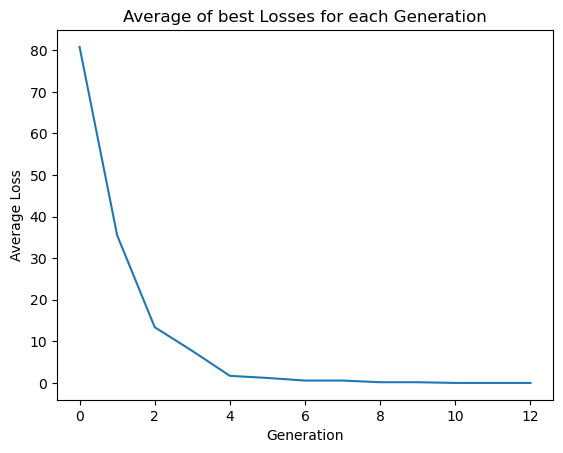

<Figure size 640x480 with 0 Axes>

In [106]:
from matplotlib import pyplot as plt

# 2.2.3 Running the genetic algorithm with our own predictions 30 times for at most 5 minutes

num_generations = None
crossover_prob = 0.9
mutation_prob = 0.05
initial_population_size = 100
elitism = 1
length_schedule = 30
time_limit = 300
engine_RUL = engine_RUL_own_predictions
stop_at_optimal = True

num_runs = 30
losses = []

for i in range(num_runs):
    best_loss_list, _ = GA_run(initial_population_size, crossover_prob,  mutation_prob, engine_RUL, elitism,  length_schedule, time_limit, num_generations, stop_at_optimal)
    losses.append(best_loss_list)

longest_generation = max(len(loss) for loss in losses)

# Fill up the shorter lists (due to less generations) with zeros untill all lists are the same length
for loss in losses:
    while len(loss) < longest_generation:
        loss.append(0)

# Calculate the average loss for each generation
average_losses = np.mean(losses, axis=0)

# Plot the average loss for each generation
plt.plot(average_losses)
plt.xlabel("Generation")
plt.ylabel("Average Loss")
plt.title("Average of best Losses for each Generation")
plt.show()

plt_223 = "average_loss_plot_2.2.3.png"
plt.savefig(plt_223)



In [107]:
# 2.2.4 we will discuss the findings in the report

# 2.3 Running the genetic algorithm with the predictions of the consultancy company

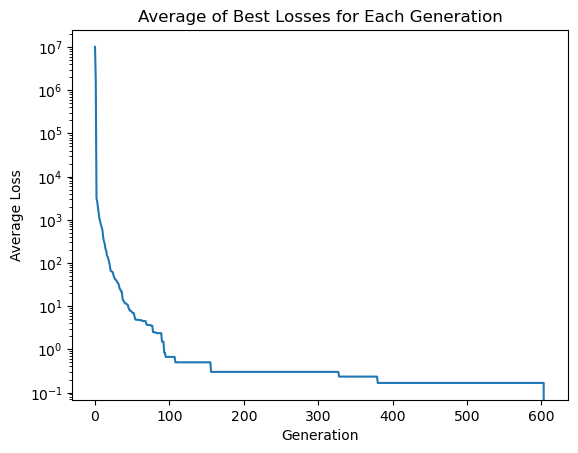

<Figure size 640x480 with 0 Axes>

In [110]:
"""Run your Genetic Algorithm on the same problem, but with the RUL predictions of the consultancy
company. Run it 30 times for at most 5 minutes, and plot the average-best-fitness."""
# 2.3.1 Running the genetic algorithm with the predictions of the consultancy company

num_generations = None
crossover_prob = 0.9
mutation_prob = 0.05
initial_population_size = 100
elitism = 1
length_schedule = 30
time_limit = 300
engine_RUL = engine_RUL_full_consultancy
stop_at_optimal = True

num_runs = 30
losses = []

for i in range(num_runs):
    best_loss_list, _ = GA_run(initial_population_size, crossover_prob,  mutation_prob, engine_RUL, elitism,  length_schedule, time_limit, num_generations, stop_at_optimal)
    losses.append(best_loss_list)
    
longest_generation = max(len(loss) for loss in losses)

# Fill up the shorter lists (due to less generations) with zeros untill all lists are the same length
for loss in losses:
    while len(loss) < longest_generation:
        loss.append(0)

# Calculate the average loss for each generation
average_losses = np.mean(losses, axis=0)

# Plot the average loss for each generation with a logarithmic scale
plt.plot(average_losses)
plt.xlabel("Generation")
plt.ylabel("Average Loss")
plt.title("Average of Best Losses for Each Generation")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

# Save the plot
plt_231 = "average_loss_plot_2.3.1.png"
plt.savefig(plt_231)

In [109]:
# 2.3.2 we will discuss the findings in the report